In [213]:
import json, pickle, os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
LEMMATIZER = WordNetLemmatizer()

In [214]:
power_folder = 'output/coref_plus_gptlexicon_outputs/'
dataset_path = '../narrative_detection/narrative_posts_by_trained_classification.csv'

load all power/agency scores output

In [215]:
with open(power_folder + 'id_persona_power_dict.json') as f:
    id_persona_power_dict = json.load(f)
with open(power_folder + 'id_persona_agency_dict.json') as f:
    id_persona_agency_dict = json.load(f)
with open(power_folder + 'id_persona_total_dict.json') as f:
    id_persona_total_dict = json.load(f)
with open(power_folder + 'id_nsubj_verb_count_dict.pkl', 'rb') as f:
    id_nsubj_verb_count_dict = pickle.load(f)
with open(power_folder + 'id_dobj_verb_count_dict.pkl', 'rb') as f:
    id_dobj_verb_count_dict = pickle.load(f)
with open(power_folder + 'id_persona_score_dict.json') as f:
    id_persona_power_score_dict = json.load(f)
with open(power_folder + 'id_persona_agency_score_dict.json') as f:
    id_persona_agency_score_dict = json.load(f)
with open(power_folder + 'id_persona_total_dict.json', 'r') as f:
    id_persona_total_dict = json.load(f)

compute scores per subreddit

In [216]:
dataset = pd.read_csv(dataset_path)
subreddit_list = dataset['subreddit'].unique().tolist()
all_texts = dataset['selftext'].tolist()
all_subs = dataset['subreddit'].tolist()

In [217]:
for sub in subreddit_list:
    # Get all texts from this subreddit
    indicies = [i for i, x in enumerate(all_subs) if x == sub]
    texts = [all_texts[i] for i in indicies]

    # Get all power and agency scores per text, per persona in this subreddit
    sub_id_persona_power_dict = {str(i): id_persona_power_dict[str(i)] for i in indicies if str(i) in id_persona_power_dict}
    sub_id_persona_agency_dict = {str(i): id_persona_agency_dict[str(i)] for i in indicies if str(i) in id_persona_agency_dict}
    sub_id_persona_power_score_dict = {str(i): id_persona_power_score_dict[str(i)] for i in indicies if str(i) in id_persona_power_score_dict}
    sub_id_persona_agency_score_dict = {str(i): id_persona_agency_score_dict[str(i)] for i in indicies if str(i) in id_persona_agency_score_dict}
    sub_id_persona_counts_total_dict = {str(i): id_persona_total_dict[str(i)] for i in indicies if str(i) in id_persona_total_dict}

    # Get persona counts in this subreddit
    persona_counts_power = defaultdict(int)
    for _id, _persona_power_dict in sub_id_persona_power_dict.items():
        for _persona in _persona_power_dict.keys():
            #persona_counts_power[_persona] += _persona_power_dict[_persona]['positive'] + _persona_power_dict[_persona]['negative']
            if 'positive' in _persona_power_dict[_persona]:
                persona_counts_power[_persona] += _persona_power_dict[_persona]['positive']
            if 'negative' in _persona_power_dict[_persona]:
                persona_counts_power[_persona] += _persona_power_dict[_persona]['negative']
            if 'equal' in _persona_power_dict[_persona]:
                persona_counts_power[_persona] += _persona_power_dict[_persona]['equal']

    persona_counts_agency = defaultdict(int)
    for _id, _persona_agency_dict in sub_id_persona_agency_dict.items():
        for _persona in _persona_agency_dict.keys():
            #persona_counts_agency[_persona] += _persona_agency_dict[_persona]['positive'] + _persona_agency_dict[_persona]['negative']
            if 'positive' in _persona_agency_dict[_persona]:
                persona_counts_agency[_persona] += _persona_agency_dict[_persona]['positive']
            if 'negative' in _persona_agency_dict[_persona]:
                persona_counts_agency[_persona] += _persona_agency_dict[_persona]['negative']
            if 'equal' in _persona_agency_dict[_persona]:
                persona_counts_agency[_persona] += _persona_agency_dict[_persona]['equal']

    persona_counts_total = defaultdict(int)
    for _id, _persona_total_dict in sub_id_persona_counts_total_dict.items():
        for _persona in _persona_total_dict.keys():
            persona_counts_total[_persona] += _persona_total_dict[_persona]

    # Get average power and agency scores per persona in this subreddit
    persona_power_scores_dict = defaultdict(list)
    for _id, _persona_score_dict in sub_id_persona_power_score_dict.items():
        for _persona, _score in _persona_score_dict.items():
            persona_power_scores_dict[_persona].append(_score)
    persona_power_score_dict = {_persona: np.mean(_scores) for _persona, _scores in persona_power_scores_dict.items()}

    persona_agency_scores_dict = defaultdict(list)
    for _id, _persona_agency_score_dict in sub_id_persona_agency_score_dict.items():
        for _persona, _score in _persona_agency_score_dict.items():
            persona_agency_scores_dict[_persona].append(_score)
    persona_agency_score_dict = {_persona: np.mean(_scores) for _persona, _scores in persona_agency_scores_dict.items()}

    # Save to file
    save_folder = power_folder + sub + '/'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    with open(save_folder + 'persona_power_score_dict.json', 'w') as f:
        json.dump(persona_power_score_dict, f, indent=4)
    with open(save_folder + 'persona_agency_score_dict.json', 'w') as f:
        json.dump(persona_agency_score_dict, f, indent=4)
    with open(save_folder + 'persona_counts_power.json', 'w') as f:
        json.dump(persona_counts_power, f, indent=4)
    with open(save_folder + 'persona_counts_agency.json', 'w') as f:
        json.dump(persona_counts_agency, f, indent=4)
    with open(save_folder + 'persona_counts_total.json', 'w') as f:
        json.dump(persona_counts_total, f, indent=4)


charts of persona power/agency per subreddit

In [218]:
power_across_subs = {}
agency_across_subs = {}

power_counts = defaultdict(dict)
agency_counts = defaultdict(dict)
total_counts = defaultdict(dict)

for sub in subreddit_list:
    with open(power_folder + sub + '/persona_power_score_dict.json') as f:
        persona_power_score_dict = json.load(f)
    with open(power_folder + sub + '/persona_agency_score_dict.json') as f:
        persona_agency_score_dict = json.load(f)
    with open(power_folder + sub + '/persona_counts_power.json') as f:
        persona_counts_power = json.load(f)
    with open(power_folder + sub + '/persona_counts_agency.json') as f:
        persona_counts_agency = json.load(f)
    with open(power_folder + sub + '/persona_counts_total.json') as f:
        persona_counts_total = json.load(f)
    
    for persona, power_score in persona_power_score_dict.items():
        if persona not in power_across_subs:
            power_across_subs[persona] = {}
        power_across_subs[persona][sub] = power_score
        power_counts[persona][sub] = persona_counts_power[persona] if persona in persona_counts_power else 0
    
    for persona, agency_score in persona_agency_score_dict.items():
        if persona not in agency_across_subs:
            agency_across_subs[persona] = {}
        agency_across_subs[persona][sub] = agency_score
        agency_counts[persona][sub] = persona_counts_agency[persona] if persona in persona_counts_agency else 0

    total_counts[sub] = persona_counts_total

In [219]:
power_across_subs_df = pd.DataFrame.from_dict(power_across_subs).T
power_counts_df = pd.DataFrame.from_dict(power_counts).T
power_counts_df.fillna(0, inplace=True)

agency_across_subs_df = pd.DataFrame.from_dict(agency_across_subs).T
agency_counts_df = pd.DataFrame.from_dict(agency_counts).T
agency_counts_df.fillna(0, inplace=True)

total_counts_df = pd.DataFrame.from_dict(total_counts)
total_counts_df.fillna(0, inplace=True)

In [220]:
# reorder and remove some columns
power_general_subs = power_across_subs_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
power_recover_subs = power_across_subs_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
power_across_subs_df = pd.concat([power_general_subs, power_recover_subs], axis=1)

# same for agency
agency_general_subs = agency_across_subs_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
agency_recover_subs = agency_across_subs_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
agency_across_subs_df = pd.concat([agency_general_subs, agency_recover_subs], axis=1)

# same for counts df
power_general_counts = power_counts_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
power_recover_counts = power_counts_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
power_counts_df = pd.concat([power_general_counts, power_recover_counts], axis=1)
power_counts_df = power_counts_df.astype(int)

agency_general_counts = agency_counts_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
agency_recover_counts = agency_counts_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
agency_counts_df = pd.concat([agency_general_counts, agency_recover_counts], axis=1)
agency_counts_df = agency_counts_df.astype(int)

# same for total counts df
total_general_counts = total_counts_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
total_recover_counts = total_counts_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
total_counts_df = pd.concat([total_general_counts, total_recover_counts], axis=1)
total_counts_df = total_counts_df.astype(int)

In [221]:
# make chart for each persona and save to file
for persona in power_across_subs_df.index:
    persona_data = power_across_subs_df.loc[persona]
    persona_counts = power_counts_df.loc[persona]

    sns.barplot(x=persona_data.index, y=persona_data.values)
    plt.title('Average power scores for ' + persona)
    plt.xlabel('Subreddit')
    plt.ylabel('Average power score')
    plt.ylim(-1.1, 1.1)
    plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts.values)
    plt.xticks(rotation=90)

    save_dir = power_folder + 'figs/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(save_dir + 'power_' + persona + '.png', bbox_inches='tight')

    # clear figure
    plt.clf()

# same but for agency
for persona in agency_across_subs_df.index:
    persona_data = agency_across_subs_df.loc[persona]
    persona_counts = agency_counts_df.loc[persona]

    sns.barplot(x=persona_data.index, y=persona_data.values)
    plt.title('Average agency scores for ' + persona)
    plt.xlabel('Subreddit')
    plt.ylabel('Average agency score')
    # y range -1 to 1
    plt.ylim(-1.1, 1.1)
    plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts.values)
    plt.xticks(rotation=90)

    save_dir = power_folder + 'figs/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(save_dir + 'agency_' + persona + '.png', bbox_inches='tight')

    # clear figure
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [104]:
persona_counts_agency

{'narrator': 1}

Across all subs

In [234]:
#power_folder = 'output/baseline_outputs/'
#power_folder = 'output/coref_only_outputs/'
power_folder = 'output/coref_plus_gptlexicon_outputs/'

In [235]:
with open(power_folder + 'persona_power_score_dict.json', 'r') as f:
    persona_power_score_dict = json.load(f)
with open(power_folder + 'persona_agency_score_dict.json', 'r') as f:
    persona_agency_score_dict = json.load(f)
with open(power_folder + 'persona_counts_power.json', 'r') as f:
    persona_counts_power = json.load(f)
with open(power_folder + 'persona_counts_agency.json', 'r') as f:
    persona_counts_agency = json.load(f)

In [236]:
# general power/agency chart across all subs (not per sub)
persona_power_score_df = pd.DataFrame.from_dict(persona_power_score_dict, orient='index').T
persona_agency_score_df = pd.DataFrame.from_dict(persona_agency_score_dict, orient='index').T
persona_counts_power_df = pd.DataFrame.from_dict(persona_counts_power, orient='index').T
persona_counts_agency_df = pd.DataFrame.from_dict(persona_counts_agency, orient='index').T

# reorder columns
persona_power_score_df = persona_power_score_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]
persona_agency_score_df = persona_agency_score_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]
persona_counts_power_df = persona_counts_power_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]
persona_counts_agency_df = persona_counts_agency_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]

In [237]:
# make chart for power
sns.barplot(data=persona_power_score_df, palette='hls')
plt.title('Average power scores for all personas')
plt.xlabel('Persona')
plt.ylabel('Average power score')
plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts_power_df.values[0])
plt.xticks(rotation=90)

save_dir = power_folder + 'figs/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(save_dir + 'power_ALL.png', bbox_inches='tight')

# clear figure
plt.clf()

# same but for agency
sns.barplot(data=persona_agency_score_df, palette='hls')
plt.title('Average agency scores for all personas')
plt.xlabel('Persona')
plt.ylabel('Average agency score')
plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts_agency_df.values[0])
plt.xticks(rotation=90)

plt.savefig(save_dir + 'agency_ALL.png', bbox_inches='tight')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [108]:
persona_power_score_df

,narrator,reader,medical_prof,friend,family,SO_any,ex_SO,food,ED
0,-0.270115,0.37532,-0.103062,-0.013668,0.046425,0.12744,-0.472181,-0.587752,-0.555872


In [109]:
persona_data = power_across_subs_df.loc['family']
persona_counts = total_counts_df.loc['family']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'EatingDisorders'),
  Text(1, 0, 'eating_disorders'),
  Text(2, 0, 'AnorexiaNervosa'),
  Text(3, 0, 'anorexiaflareuphelp'),
  Text(4, 0, 'bulimia'),
  Text(5, 0, 'BingeEatingDisorder'),
  Text(6, 0, 'bingeeating'),
  Text(7, 0, 'EatingDisorderHope'),
  Text(8, 0, 'edsupport'),
  Text(9, 0, 'EDAnonymous'),
  Text(10, 0, 'EdAnonymousAdults'),
  Text(11, 0, 'EDRecovery_public'),
  Text(12, 0, 'AnorexiaRecovery'),
  Text(13, 0, 'BulimiaRecovery'),
  Text(14, 0, 'BulimiaAndAnaSupport')])

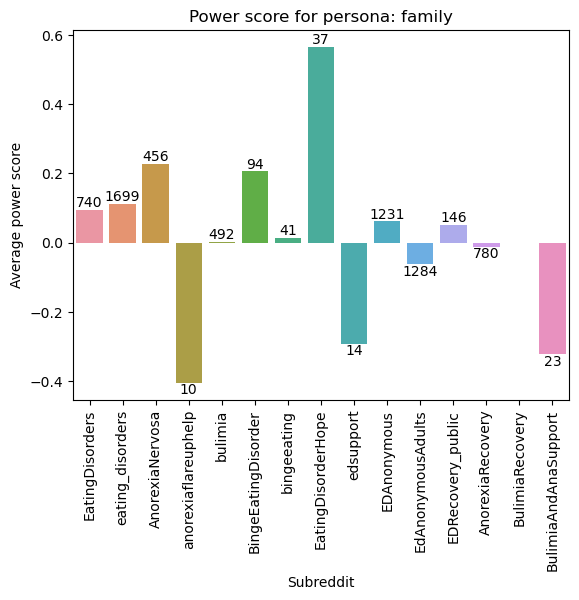

In [110]:
sns.barplot(x=persona_data.index, y=persona_data.values)
plt.title('Power score for persona: family')
plt.xlabel('Subreddit')
plt.ylabel('Average power score')
plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts.values)
plt.xticks(rotation=90)

compare verb counts 

In [127]:
original_lexicon = pd.read_csv('FramesAgencyPower/agency_power.csv')
original_lexicon['verb'] = original_lexicon['verb'].apply(lambda x: LEMMATIZER.lemmatize(x, pos='v').lower())

final_lexicon = pd.read_csv('data/final_lexicon.csv')

In [134]:
original_lexicon_dict = {v: {'agency': a, 'power': p} for v, a, p in zip(original_lexicon['verb'], original_lexicon['agency'], original_lexicon['power'])}
final_lexicon_dict = {v: {'agency': a, 'power': p} for v, a, p in zip(final_lexicon['verb'], final_lexicon['agency'], final_lexicon['power'])}

In [115]:
with open('output/baseline_outputs/id_nsubj_verb_count_dict.pkl', 'rb') as f:
    baseline_id_nsubj_verb_counts = pickle.load(f)
with open('output/baseline_outputs/id_dobj_verb_count_dict.pkl', 'rb') as f:
    baseline_id_dobj_verb_counts = pickle.load(f)

with open('output/coref_only_outputs/id_nsubj_verb_count_dict.pkl', 'rb') as f:
    coref_id_nsubj_verb_counts = pickle.load(f)
with open('output/coref_only_outputs/id_dobj_verb_count_dict.pkl', 'rb') as f:
    coref_id_dobj_verb_counts = pickle.load(f)

with open('output/coref_plus_gptlexicon_outputs/id_nsubj_verb_count_dict.pkl', 'rb') as f:
    gptlexicon_id_nsubj_verb_counts = pickle.load(f)
with open('output/coref_plus_gptlexicon_outputs/id_dobj_verb_count_dict.pkl', 'rb') as f:
    gptlexicon_id_dobj_verb_counts = pickle.load(f)

In [118]:
gptlexicon_id_dobj_verb_counts == coref_id_dobj_verb_counts

True

In [139]:
from datetime import datetime
import sys
sys.path.append('power-frames/')
from power_frames import measure_power_per_document, measure_agency_per_document, get_persona_totals_per_document, get_verb_power_dict, get_verb_agency_dict

In [140]:
original_lexicon_path = 'FramesAgencyPower/agency_power.csv'
original_verb_power_dict = get_verb_power_dict(original_lexicon_path)
original_verb_agency_dict = get_verb_agency_dict(original_lexicon_path)

final_lexicon_path = 'data/final_lexicon.csv'
final_verb_power_dict = get_verb_power_dict(final_lexicon_path)
final_verb_agency_dict = get_verb_agency_dict(final_lexicon_path)

In [141]:
story_ids = [str(i) for i in range(7676)]

In [146]:
def measure_power(verb_power_dict, verb_agency_dict, id_nsubj_verb_count_dict, id_dobj_verb_count_dict, text_ids):

    id_persona_power_dict = {}
    id_persona_agency_dict = {}
    id_persona_total_dict = {}

    j = 0

    for _id in text_ids:

        if j % 100 == 0:
            print(str(datetime.now())[:-7] + ' Processed ' + str(j) + ' out of ' + str(len(text_ids)))
        j += 1

        _nsubj_verb_count_dict = id_nsubj_verb_count_dict[_id]
        _dobj_verb_count_dict = id_dobj_verb_count_dict[_id]

        _persona_power_dict = measure_power_per_document(_nsubj_verb_count_dict, _dobj_verb_count_dict, verb_power_dict)
        _persona_agency_dict = measure_agency_per_document(_nsubj_verb_count_dict, verb_agency_dict)
        _persona_total_dict = get_persona_totals_per_document(_nsubj_verb_count_dict, _dobj_verb_count_dict)

        id_persona_power_dict[_id] = _persona_power_dict
        id_persona_agency_dict[_id] = _persona_agency_dict
        id_persona_total_dict[_id] = _persona_total_dict
        id_nsubj_verb_count_dict[_id] = _nsubj_verb_count_dict
        id_dobj_verb_count_dict[_id] = _dobj_verb_count_dict

    return id_persona_power_dict, id_persona_agency_dict, id_persona_total_dict

In [147]:
id_persona_power_dict_BASELINE, id_persona_agency_dict_BASELINE, id_persona_total_dict_BASELINE = measure_power(original_verb_power_dict, original_verb_agency_dict, baseline_id_nsubj_verb_counts, baseline_id_dobj_verb_counts, story_ids)

2023-05-16 16:12:36 Processed 0 out of 7676
2023-05-16 16:12:36 Processed 100 out of 7676
2023-05-16 16:12:36 Processed 200 out of 7676
2023-05-16 16:12:36 Processed 300 out of 7676
2023-05-16 16:12:36 Processed 400 out of 7676
2023-05-16 16:12:36 Processed 500 out of 7676
2023-05-16 16:12:36 Processed 600 out of 7676
2023-05-16 16:12:36 Processed 700 out of 7676
2023-05-16 16:12:36 Processed 800 out of 7676
2023-05-16 16:12:36 Processed 900 out of 7676
2023-05-16 16:12:36 Processed 1000 out of 7676
2023-05-16 16:12:36 Processed 1100 out of 7676
2023-05-16 16:12:36 Processed 1200 out of 7676
2023-05-16 16:12:36 Processed 1300 out of 7676
2023-05-16 16:12:36 Processed 1400 out of 7676
2023-05-16 16:12:36 Processed 1500 out of 7676
2023-05-16 16:12:36 Processed 1600 out of 7676
2023-05-16 16:12:36 Processed 1700 out of 7676
2023-05-16 16:12:36 Processed 1800 out of 7676
2023-05-16 16:12:36 Processed 1900 out of 7676
2023-05-16 16:12:36 Processed 2000 out of 7676
2023-05-16 16:12:36 Proce

In [149]:
# save to file
with open('output/baseline_outputs/id_persona_power_dict.json', 'w') as f:
    json.dump(id_persona_power_dict_BASELINE, f, indent=4)
with open('output/baseline_outputs/id_persona_agency_dict.json', 'w') as f:
    json.dump(id_persona_agency_dict_BASELINE, f, indent=4)
with open('output/baseline_outputs/id_persona_total_dict.json', 'w') as f:
    json.dump(id_persona_total_dict_BASELINE, f, indent=4)

In [265]:
id_persona_power_dict_GPTONLY, id_persona_agency_dict_GPTONLY, id_persona_total_dict_GPTONLY = measure_power(final_verb_power_dict, final_verb_agency_dict, baseline_id_nsubj_verb_counts, baseline_id_dobj_verb_counts, story_ids)

2023-05-16 20:50:12 Processed 0 out of 7676
2023-05-16 20:50:12 Processed 100 out of 7676
2023-05-16 20:50:12 Processed 200 out of 7676
2023-05-16 20:50:12 Processed 300 out of 7676
2023-05-16 20:50:12 Processed 400 out of 7676
2023-05-16 20:50:12 Processed 500 out of 7676
2023-05-16 20:50:12 Processed 600 out of 7676
2023-05-16 20:50:12 Processed 700 out of 7676
2023-05-16 20:50:12 Processed 800 out of 7676
2023-05-16 20:50:12 Processed 900 out of 7676
2023-05-16 20:50:12 Processed 1000 out of 7676
2023-05-16 20:50:12 Processed 1100 out of 7676
2023-05-16 20:50:12 Processed 1200 out of 7676
2023-05-16 20:50:12 Processed 1300 out of 7676
2023-05-16 20:50:12 Processed 1400 out of 7676
2023-05-16 20:50:12 Processed 1500 out of 7676
2023-05-16 20:50:12 Processed 1600 out of 7676
2023-05-16 20:50:12 Processed 1700 out of 7676
2023-05-16 20:50:12 Processed 1800 out of 7676
2023-05-16 20:50:12 Processed 1900 out of 7676
2023-05-16 20:50:12 Processed 2000 out of 7676
2023-05-16 20:50:12 Proce

In [266]:
# save to file
with open('output/gpt_only_outputs/id_persona_power_dict.json', 'w') as f:
    json.dump(id_persona_power_dict_GPTONLY, f, indent=4)
with open('output/gpt_only_outputs/id_persona_agency_dict.json', 'w') as f:
    json.dump(id_persona_agency_dict_GPTONLY, f, indent=4)
with open('output/gpt_only_outputs/id_persona_total_dict.json', 'w') as f:
    json.dump(id_persona_total_dict_GPTONLY, f, indent=4)

In [150]:
id_persona_power_dict_COREF, id_persona_agency_dict_COREF, id_persona_total_dict_COREF = measure_power(original_verb_power_dict, original_verb_agency_dict, coref_id_nsubj_verb_counts, coref_id_dobj_verb_counts, story_ids)

2023-05-16 16:18:20 Processed 0 out of 7676
2023-05-16 16:18:20 Processed 100 out of 7676
2023-05-16 16:18:20 Processed 200 out of 7676
2023-05-16 16:18:20 Processed 300 out of 7676
2023-05-16 16:18:20 Processed 400 out of 7676
2023-05-16 16:18:20 Processed 500 out of 7676
2023-05-16 16:18:20 Processed 600 out of 7676
2023-05-16 16:18:20 Processed 700 out of 7676
2023-05-16 16:18:20 Processed 800 out of 7676
2023-05-16 16:18:20 Processed 900 out of 7676
2023-05-16 16:18:20 Processed 1000 out of 7676
2023-05-16 16:18:20 Processed 1100 out of 7676
2023-05-16 16:18:20 Processed 1200 out of 7676
2023-05-16 16:18:20 Processed 1300 out of 7676
2023-05-16 16:18:20 Processed 1400 out of 7676
2023-05-16 16:18:20 Processed 1500 out of 7676
2023-05-16 16:18:20 Processed 1600 out of 7676
2023-05-16 16:18:20 Processed 1700 out of 7676
2023-05-16 16:18:20 Processed 1800 out of 7676
2023-05-16 16:18:20 Processed 1900 out of 7676
2023-05-16 16:18:20 Processed 2000 out of 7676
2023-05-16 16:18:20 Proce

In [151]:
# save to file
with open('output/coref_only_outputs/id_persona_power_dict.json', 'w') as f:
    json.dump(id_persona_power_dict_COREF, f, indent=4)
with open('output/coref_only_outputs/id_persona_agency_dict.json', 'w') as f:
    json.dump(id_persona_agency_dict_COREF, f, indent=4)
with open('output/coref_only_outputs/id_persona_total_dict.json', 'w') as f:
    json.dump(id_persona_total_dict_COREF, f, indent=4)

In [152]:
id_persona_power_dict_GPT, id_persona_agency_dict_GPT, id_persona_total_dict_GPT = measure_power(final_verb_power_dict, final_verb_agency_dict, gptlexicon_id_nsubj_verb_counts, gptlexicon_id_dobj_verb_counts, story_ids)

2023-05-16 16:19:42 Processed 0 out of 7676
2023-05-16 16:19:42 Processed 100 out of 7676
2023-05-16 16:19:42 Processed 200 out of 7676
2023-05-16 16:19:42 Processed 300 out of 7676
2023-05-16 16:19:42 Processed 400 out of 7676
2023-05-16 16:19:42 Processed 500 out of 7676
2023-05-16 16:19:42 Processed 600 out of 7676
2023-05-16 16:19:42 Processed 700 out of 7676
2023-05-16 16:19:42 Processed 800 out of 7676
2023-05-16 16:19:42 Processed 900 out of 7676
2023-05-16 16:19:42 Processed 1000 out of 7676
2023-05-16 16:19:42 Processed 1100 out of 7676
2023-05-16 16:19:42 Processed 1200 out of 7676
2023-05-16 16:19:42 Processed 1300 out of 7676
2023-05-16 16:19:42 Processed 1400 out of 7676
2023-05-16 16:19:42 Processed 1500 out of 7676
2023-05-16 16:19:42 Processed 1600 out of 7676
2023-05-16 16:19:42 Processed 1700 out of 7676
2023-05-16 16:19:42 Processed 1800 out of 7676
2023-05-16 16:19:42 Processed 1900 out of 7676
2023-05-16 16:19:42 Processed 2000 out of 7676
2023-05-16 16:19:42 Proce

In [153]:
# save to file
with open('output/coref_plus_gptlexicon_outputs/id_persona_power_dict.json', 'w') as f:
    json.dump(id_persona_power_dict_GPT, f, indent=4)
with open('output/coref_plus_gptlexicon_outputs/id_persona_agency_dict.json', 'w') as f:
    json.dump(id_persona_agency_dict_GPT, f, indent=4)
with open('output/coref_plus_gptlexicon_outputs/id_persona_total_dict.json', 'w') as f:
    json.dump(id_persona_total_dict_GPT, f, indent=4)

In [154]:
# get persona counts
def get_persona_counts(id_persona_power_dict, id_persona_agency_dict):
    persona_counts_power = defaultdict(int)
    for _id, _persona_power_dict in id_persona_power_dict.items():
        for _persona in _persona_power_dict.keys():
            persona_counts_power[_persona] += _persona_power_dict[_persona]['positive'] + _persona_power_dict[_persona]['negative'] + _persona_power_dict[_persona]['equal']

    persona_counts_agency = defaultdict(int)
    for _id, _persona_agency_dict in id_persona_agency_dict.items():
        for _persona in _persona_agency_dict.keys():
            persona_counts_agency[_persona] += _persona_agency_dict[_persona]['positive'] + _persona_agency_dict[_persona]['negative'] + _persona_agency_dict[_persona]['equal']
    
    return persona_counts_power, persona_counts_agency

In [158]:
persona_counts_power_BASELINE, persona_counts_agency_BASELINE = get_persona_counts(id_persona_power_dict_BASELINE, id_persona_agency_dict_BASELINE)
persona_counts_power_COREF, persona_counts_agency_COREF = get_persona_counts(id_persona_power_dict_COREF, id_persona_agency_dict_COREF)
persona_counts_power_GPT, persona_counts_agency_GPT = get_persona_counts(id_persona_power_dict_GPT, id_persona_agency_dict_GPT)

In [267]:
persona_counts_power_GPTONLY, persona_counts_agency_GPTONLY = get_persona_counts(id_persona_power_dict_GPTONLY, id_persona_agency_dict_GPTONLY)

# save to file
with open('output/gpt_only_outputs/persona_counts_power.json', 'w') as f:
    json.dump(persona_counts_power_GPTONLY, f, indent=4)
with open('output/gpt_only_outputs/persona_counts_agency.json', 'w') as f:
    json.dump(persona_counts_agency_GPTONLY, f, indent=4)

In [159]:
# save to file
with open('output/baseline_outputs/persona_counts_power.json', 'w') as f:
    json.dump(persona_counts_power_BASELINE, f, indent=4)
with open('output/baseline_outputs/persona_counts_agency.json', 'w') as f:
    json.dump(persona_counts_agency_BASELINE, f, indent=4)
with open('output/coref_only_outputs/persona_counts_power.json', 'w') as f:
    json.dump(persona_counts_power_COREF, f, indent=4)
with open('output/coref_only_outputs/persona_counts_agency.json', 'w') as f:
    json.dump(persona_counts_agency_COREF, f, indent=4)
with open('output/coref_plus_gptlexicon_outputs/persona_counts_power.json', 'w') as f:
    json.dump(persona_counts_power_GPT, f, indent=4)
with open('output/coref_plus_gptlexicon_outputs/persona_counts_agency.json', 'w') as f:
    json.dump(persona_counts_agency_GPT, f, indent=4)

In [171]:
def compute_score_per_id(id_persona_power_dict, id_persona_agency_dict, id_persona_total_dict):
    id_persona_score_dict = defaultdict(lambda: defaultdict(float))
    for _id, _persona_power_dict in id_persona_power_dict.items():
        for _persona, _polarity_score_dict in _persona_power_dict.items():
            _score = _polarity_score_dict['positive'] - _polarity_score_dict['negative']
            _score /= id_persona_total_dict[_id][_persona]
            id_persona_score_dict[_id][_persona] = _score
    
    id_persona_agency_score_dict = defaultdict(lambda: defaultdict(float))
    for _id, _persona_agency_dict in id_persona_agency_dict.items():
        for _persona, _polarity_score_dict in _persona_agency_dict.items():
            _score = _polarity_score_dict['positive'] - _polarity_score_dict['negative']
            #_score /= id_persona_total_dict[_id][_persona]
            _score /= sum(id_persona_agency_dict[_id][_persona].values())
            id_persona_agency_score_dict[_id][_persona] = _score
    
    return id_persona_score_dict, id_persona_agency_score_dict

In [175]:
id_persona_score_dict_BASELINE, id_persona_agency_score_dict_BASELINE = compute_score_per_id(id_persona_power_dict_BASELINE, id_persona_agency_dict_BASELINE, id_persona_total_dict_BASELINE)
id_persona_score_dict_COREF, id_persona_agency_score_dict_COREF = compute_score_per_id(id_persona_power_dict_COREF, id_persona_agency_dict_COREF, id_persona_total_dict_COREF)
id_persona_score_dict_GPT, id_persona_agency_score_dict_GPT = compute_score_per_id(id_persona_power_dict_GPT, id_persona_agency_dict_GPT, id_persona_total_dict_GPT)

In [268]:
id_persona_score_dict_GPTONLY, id_persona_agency_score_dict_GPTONLY = compute_score_per_id(id_persona_power_dict_GPTONLY, id_persona_agency_dict_GPTONLY, id_persona_total_dict_GPTONLY)

# save to file
with open('output/gpt_only_outputs/id_persona_score_dict.json', 'w') as f:
    json.dump(id_persona_score_dict_GPTONLY, f, indent=4)
with open('output/gpt_only_outputs/id_persona_agency_score_dict.json', 'w') as f:
    json.dump(id_persona_agency_score_dict_GPTONLY, f, indent=4)

In [176]:
# save to file
with open('output/baseline_outputs/id_persona_score_dict.json', 'w') as f:
    json.dump(id_persona_score_dict_BASELINE, f, indent=4)
with open('output/baseline_outputs/id_persona_agency_score_dict.json', 'w') as f:
    json.dump(id_persona_agency_score_dict_BASELINE, f, indent=4)
with open('output/coref_only_outputs/id_persona_score_dict.json', 'w') as f:
    json.dump(id_persona_score_dict_COREF, f, indent=4)
with open('output/coref_only_outputs/id_persona_agency_score_dict.json', 'w') as f:
    json.dump(id_persona_agency_score_dict_COREF, f, indent=4)
with open('output/coref_plus_gptlexicon_outputs/id_persona_score_dict.json', 'w') as f:
    json.dump(id_persona_score_dict_GPT, f, indent=4)
with open('output/coref_plus_gptlexicon_outputs/id_persona_agency_score_dict.json', 'w') as f:
    json.dump(id_persona_agency_score_dict_GPT, f, indent=4)

Compare persona counts

In [269]:
persona_counts_power = {persona: {'baseline': 0, 'coref': 0, 'gpt': 0, 'coref_gpt': 0} for persona in persona_counts_power_BASELINE.keys()}
persona_counts_agency = {persona: {'baseline': 0, 'coref': 0, 'gpt': 0, 'coref_gpt': 0} for persona in persona_counts_power_BASELINE.keys()}

for persona, count in persona_counts_power_BASELINE.items():
    persona_counts_power[persona]['baseline'] = count
for persona, count in persona_counts_power_COREF.items():
    persona_counts_power[persona]['coref'] = count
for persona, count in persona_counts_power_GPT.items():
    persona_counts_power[persona]['coref_gpt'] = count
for persona, count in persona_counts_power_GPTONLY.items():
    persona_counts_power[persona]['gpt'] = count

for persona, count in persona_counts_agency_BASELINE.items():
    persona_counts_agency[persona]['baseline'] = count
for persona, count in persona_counts_agency_COREF.items():
    persona_counts_agency[persona]['coref'] = count
for persona, count in persona_counts_agency_GPT.items():
    persona_counts_agency[persona]['coref_gpt'] = count
for persona, count in persona_counts_agency_GPTONLY.items():
    persona_counts_agency[persona]['gpt'] = count

In [273]:
power_df = pd.DataFrame(persona_counts_power)
agency_df = pd.DataFrame(persona_counts_agency)

# reorder columns
power_df = power_df[['narrator', 'reader', 'SO_male', 'SO_female', 'SO_neutral', 'SO_any',  'ex_SO', 'friend', 'family', 'nurse', 'doctor', 'therapist', 'medical_prof', 'ED', 'food']]
agency_df = agency_df[['narrator', 'reader', 'SO_male', 'SO_female', 'SO_neutral','SO_any',  'ex_SO', 'friend', 'family', 'nurse', 'doctor', 'therapist', 'medical_prof', 'ED', 'food']]

power_df = power_df.T
agency_df = agency_df.T

In [279]:
agency_df['percent_increase_coref'] = (agency_df['coref'] - agency_df['baseline']) / agency_df['baseline'] * 100
power_df['percent_increase_coref'] = (power_df['coref'] - power_df['baseline']) / power_df['baseline'] * 100

agency_df['percent_increase_gpt'] = (agency_df['gpt'] - agency_df['baseline']) / agency_df['baseline'] * 100
power_df['percent_increase_gpt'] = (power_df['gpt'] - power_df['baseline']) / power_df['baseline'] * 100

agency_df['percent_increase_coref_gpt'] = (agency_df['coref_gpt'] - agency_df['baseline']) / agency_df['baseline'] * 100
power_df['percent_increase_coref_gpt'] = (power_df['coref_gpt'] - power_df['baseline']) / power_df['baseline'] * 100

In [277]:
test = power_df.T
test['TOTAL'] = test.sum(axis=1)

power_df = test.T

In [280]:
power_df

,baseline,coref,gpt,coref_gpt,percent_increase_coref,percent_increase_gpt,percent_increase_coref_gpt
narrator,17863.0,19775.0,19107.0,21083.0,10.703689,6.964116,18.026087
reader,5149.0,5392.0,5527.0,5778.0,4.719363,7.341231,12.215964
SO_male,435.0,1309.0,450.0,1374.0,200.919540,3.448276,215.862069
SO_female,108.0,638.0,111.0,678.0,490.740741,2.777778,527.777778
SO_neutral,163.0,490.0,174.0,522.0,200.613497,6.748466,220.245399
SO_any,706.0,2437.0,735.0,2574.0,245.184136,4.107649,264.589235
ex_SO,1429.0,1801.0,1507.0,1918.0,26.032190,5.458362,34.219734
friend,1022.0,3202.0,1069.0,3394.0,213.307241,4.598826,232.093933
family,2353.0,5301.0,2502.0,5657.0,125.286868,6.332342,140.416490
nurse,104.0,134.0,124.0,157.0,28.846154,19.230769,50.961538


In [281]:
agency_df.to_csv('output/agency_counts.csv')
power_df.to_csv('output/power_counts.csv')